In [13]:
from iris_lmsalpy import hcr2fits, extract_irisL2data
import matplotlib.pyplot as plt
import numpy as np
import cv2
%matplotlib inline

# query_text = "https://www.lmsal.com/hek/hcr?cmd=search-events3&outputformat=json&startTime=2017-10-25T04:00&stopTime=2017-10-25T05:00&minnumRasterSteps=320&herEvents=SS&hasData=true&limit=200"
# list_urls = hcr2fits.get_fits(query_text)



The provided file is a raster IRIS Level 2 data file.

Extracting information from file iris_l2_20160114_230409_3630008076_raster_t000_r00000.fits... 

Available data with size Y x X x Wavelength are stored in windows labeled as:

--------------------------------------------------------------------
Index --- Window label --- Y x X x WL --- Spectral range [AA] (band)
--------------------------------------------------------------------
  0 	 C II 1336    	   779x320x374 	   1332.66 - 1337.50  (FUV)
  1 	 Fe XII 1349  	   779x320x245 	   1347.62 - 1350.79  (FUV)
  2 	 O I 1356     	   779x320x340 	   1352.19 - 1356.59  (FUV)
  3 	 Si IV 1394   	   779x320x411 	   1390.87 - 1396.08  (FUV)
  4 	 Si IV 1403   	   779x320x602 	   1398.59 - 1406.23  (FUV)
  5 	 2832         	   779x320x113 	   2831.38 - 2834.23  (NUV)
  6 	 2814         	   779x320x146 	   2812.69 - 2816.38  (NUV)
  7 	 Mg II k 2796 	   779x320x530 	   2793.14 - 2806.61  (NUV)
------------------------------------------------

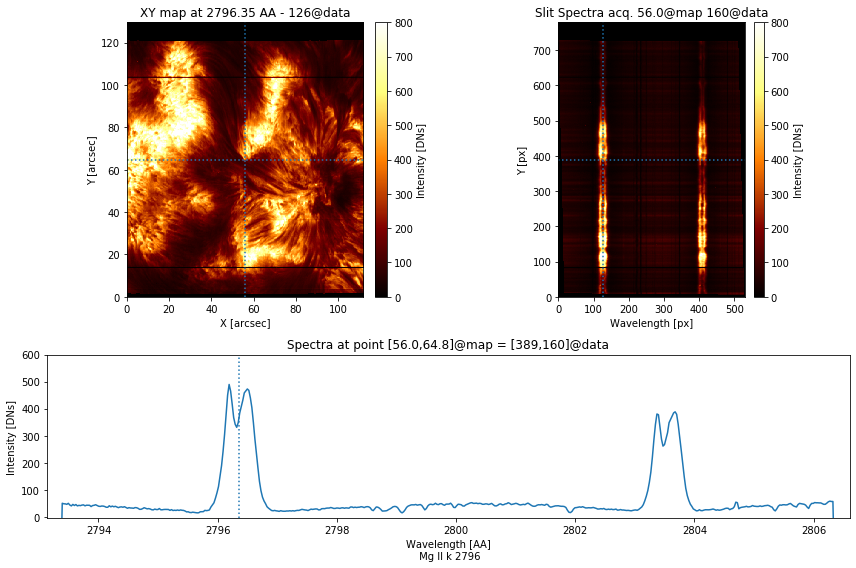

<Figure size 432x288 with 0 Axes>

In [27]:
raster_filename = "iris_l2_20160114_230409_3630008076_raster_t000_r00000.fits"
iris_raster = extract_irisL2data.load(
    raster_filename, window_info=['Mg II k 2796'], verbose=True
)
iris_raster.quick_look()

198 32.5 389 160


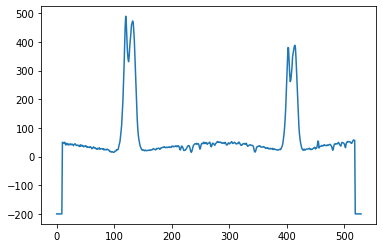

In [28]:
r = iris_raster.raster['Mg II k 2796']
s = r.data.shape
d = r.data[int(s[0]/2), int(s[1]/2), :]

delta = 50

# start, number of points
best = [None, 0]
curr = [0, 0]

for i in range(len(d) - 1):
    diff = abs(d[i] - d[i+1])
    if diff < delta:
        curr[1] += 1
    else:
        if best[1] < curr[1]:
            best = curr.copy()
        curr[0], curr[1] = i, 0

best_wl = int(sum(best) / 2)
print(best_wl, d[best_wl], int(s[0]/2), int(s[1]/2))
plt.plot(d)

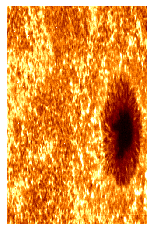

In [51]:
plt.imshow(r.data[:, :, 50], cmap=r.cmap)
plt.clim([0, 80])
plt.ylim(100, 600)
plt.axis('off')
plt.savefig("working_image", bbox_inches='tight', pad_inches=0)

In [55]:
r.data[100, 0, :]

memmap([-200.  , -200.  , -200.  , -200.  , -200.  , -200.  , -200.  ,
        -200.  , -200.  , -200.  , -200.  , -200.  , -200.  , -200.  ,
        -200.  , -200.  , -200.  ,   50.  ,   49.75,   46.  ,   46.25,
          49.  ,   47.75,   47.  ,   47.5 ,   49.  ,   47.75,   48.25,
          47.75,   46.25,   48.5 ,   48.25,   46.75,   48.  ,   45.25,
          45.  ,   47.75,   45.5 ,   44.75,   44.5 ,   43.75,   42.25,
          42.25,   44.  ,   43.5 ,   41.75,   40.75,   42.25,   40.5 ,
          43.25,   42.5 ,   38.5 ,   37.75,   39.25,   40.75,   36.5 ,
          38.  ,   37.  ,   37.5 ,   37.5 ,   36.75,   29.75,   29.25,
          33.75,   37.  ,   36.25,   34.5 ,   33.25,   34.  ,   36.75,
          32.5 ,   29.  ,   31.75,   32.75,   29.  ,   31.25,   29.75,
          30.5 ,   31.  ,   30.5 ,   31.  ,   31.5 ,   30.25,   28.75,
          28.  ,   28.25,   25.5 ,   28.  ,   28.25,   23.  ,   22.75,
          26.  ,   23.5 ,   20.25,   16.5 ,   19.  ,   18.  ,   13.75,
      

In [19]:
del iris_raster
del r, d

NameError: name 'r' is not defined

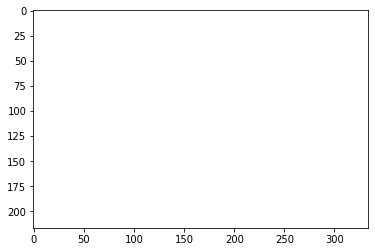

In [12]:
# opens in BGR colorspace, convert to RGB
img = cv2.cvtColor(cv2.imread("working_image.png"), cv2.COLOR_BGR2RGB)
plt.imshow(img)

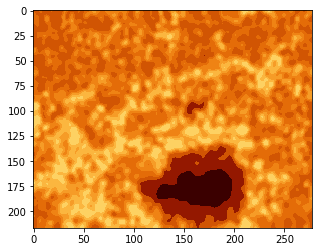

In [161]:
img_orig = img.copy()

# blur image to help smooth out edges
img = cv2.GaussianBlur(img, (7, 7), 0)

# convert to the shape of a vector of pixel values
Z = img.reshape((-1,3))
Z = np.float32(Z)

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 8
ret, label, center = cv2.kmeans(Z, K, None, criteria, 50, cv2.KMEANS_RANDOM_CENTERS)
label = label.flatten()

# Convert back to uint8 and size of original image
center = np.uint8(center)
segmented = center[label.flatten()]
segmented = segmented.reshape((img.shape))

plt.imshow(segmented)

In [149]:
def find_threshold(img, label_name):
    masked_image = np.copy(img)

    # convert to shape of label array
    masked_image = masked_image.reshape((-1, 3))

    # make all pixels without that are not specified label white
    masked_image[~(label == label_name)] = [255, 255, 255]

    # convert back to original shape
    masked_image = masked_image.reshape(img.shape)
    plt.imshow(masked_image)
    plt.show()
    
    # erode then dilate the image to remove noise
    kernel = np.ones((7,7),np.uint8)
    masked_image = cv2.morphologyEx(masked_image, cv2.MORPH_OPEN, kernel, iterations=1)
    gray = cv2.cvtColor(masked_image,cv2.COLOR_BGR2GRAY)

    # threshold image by removing all white pixels (not in label) 
    ret, thresh = cv2.threshold(gray, 254, 255, cv2.THRESH_BINARY_INV)
    
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    # create mask by only including large contours
    mask = np.zeros(masked_image.shape[:2], np.uint8)

    for c in contours:
        area = cv2.contourArea(c)
        if area < 100:
            break

        cv2.drawContours(mask, [c], -1, (255), -1)

    # by combining foreground and background, allows specification of background color (white)
    # if don't do, background will be solid black, which is same color as sunspot so problematic
    foreground = cv2.bitwise_or(masked_image, masked_image, mask=mask)
    mask = cv2.bitwise_not(mask)
    background = np.full(masked_image.shape, 255, dtype=np.uint8)
    background = cv2.bitwise_or(background, background, mask=mask)

    combine = cv2.bitwise_or(foreground, background)
    combine_gray = cv2.cvtColor(combine, cv2.COLOR_BGR2GRAY)

    # threshold image again
    ret, thresh = cv2.threshold(combine_gray, 245, 255, cv2.THRESH_BINARY_INV)
    
    return thresh

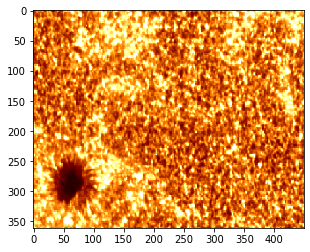

[(7060, 5), (32929, 4), (50162, 0), (66920, 6), (82966, 7), (100586, 1), (126353, 2), (158521, 3)]


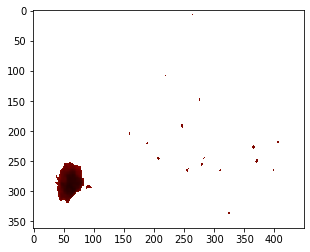

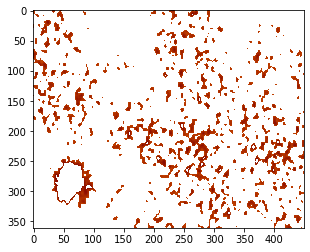

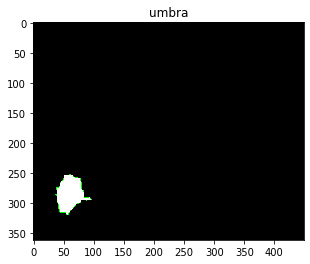

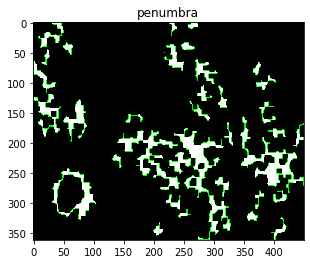

In [150]:
plt.imshow(img_orig)
plt.show()

thresholds = []
# center is a list of colors from the segmentation, sort to find closest to black
# euclidean distance is not ideal for colors, but it's seems okay
center_sort = sorted([(x[0]**2 + x[1]**2 + x[2]**2, i) for i,x in enumerate(center)])

print(center_sort)
if center_sort[0][0] > 20000:
    print("No sunspots found")
else:
    sunspot = [find_threshold(img, center_sort[0][1]),
               find_threshold(img, center_sort[1][1])]
    
    for i, t in enumerate(sunspot):

        # use RETR_TREE so inside circle of penumbra gets shown as contour
        cnt, _ = cv2.findContours(t, 
                                cv2.RETR_TREE,
                                cv2.CHAIN_APPROX_SIMPLE)
                                
        final = cv2.cvtColor(t, cv2.COLOR_GRAY2RGB)
        cv2.drawContours(final, cnt, -1, (0,255,0), 1)

        plt.imshow(final)
        plt.title(['umbra', 'penumbra'][i])
        plt.show()

    

In [145]:
import os
os.remove("working_image.png")